# Classificaton LMPP/ProB

In [10]:
import os
import argparse
import numpy as np
import six
import six.moves.cPickle as pickle
import matplotlib.pyplot as plt
import matplotlib as mlp

import chainer
import chainer.functions as F
from chainer import cuda
from chainer import optimizers
from chainer import computational_graph as c

import sklearn
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score, KFold

In [11]:
%matplotlib inline

In [12]:
#np.random.seed(0)

### Load&Prepare data

In [21]:
dpath=os.path.abspath("")
foldername = "/data"

In [22]:
lmpp = np.load(dpath+foldername+"/lmpp_data.npy")
prob = np.load(dpath+foldername+"/prob_data.npy")
prob.shape

(90, 90, 2992)

In [23]:
shuffle = np.random.permutation(len(prob[0,0,:]))
prob_dat = np.asarray(prob[:,:,shuffle])[:,:,:len(lmpp[0,0,:])]
x_data = np.dstack((lmpp,prob_dat))

In [24]:
t_data = np.r_[
        np.zeros(len(lmpp[0,0,:])),
        np.ones(len(lmpp[0,0,:])),
    ]

In [25]:
x_data =x_data[np.newaxis,:,:,:]
x_data = x_data.transpose(3,0,1,2).astype(np.float32)
t_data = t_data.astype(np.int32)
x_data.shape

(1168, 1, 90, 90)

## 1 Classificaton using size data

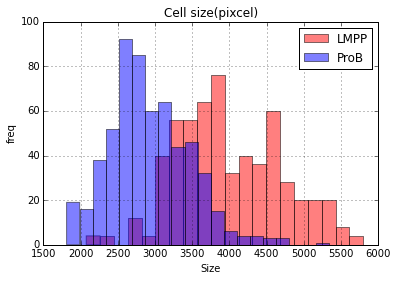

In [26]:
lmpp_area=np.sum(lmpp != 0, axis=(0,1))
prob_area=np.sum(prob_dat != 0, axis=(0,1))

lmpp_mean=np.sum(lmpp , axis=(0,1))/lmpp_area
prob_mean=np.sum(prob_dat , axis=(0,1))/prob_area

fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(212)

ax1.hist(lmpp_area,bins=20, color='red',alpha=0.5, label="LMPP")
ax1.hist(prob_area,bins=20, color='blue',alpha=0.5, label="ProB" )
ax1.set_title('Cell size(pixcel)')
ax1.set_xlabel('Size')
ax1.set_ylabel('freq')
ax1.grid(True)
ax1.legend(loc="upper right")

#ax2.hist(lmpp_mean,bins=20, color='red',alpha=0.5, label="LMPP")
#ax2.hist(prob_mean,bins=20, color='blue',alpha=0.5, label="ProB" )
#ax2.set_title('average blightness')
#ax2.set_xlabel('mean')
#ax2.set_ylabel('freq')
#ax2.grid(True)
#ax2.legend(loc="upper right")

fig.show()
#plt.savefig('cellsize.png')

In [27]:
area = np.r_[lmpp_area, prob_area]
mean = np.r_[lmpp_mean, prob_mean]
shuffle = np.random.permutation(len(t_data))
data = np.vstack((area,mean)).transpose(1,0)

data = np.asarray(data[shuffle]) 
area = np.asarray(area[shuffle]) 
label = np.asarray(t_data[shuffle])

### 5-th cross validation

In [28]:
scores_area = cross_val_score(linear_model.LogisticRegression(), area[:, np.newaxis], label, cv=5)
scores_area_mean = cross_val_score(linear_model.LogisticRegression(), data, label, cv=5)
print "size", scores_area
print "size", np.mean(scores_area)
print "size and mean", scores_area_mean
print "size and mean", np.mean(scores_area_mean)

size [ 0.81623932  0.75641026  0.76923077  0.77777778  0.85775862]
size 0.79548334807
size and mean [ 0.82051282  0.75641026  0.77350427  0.79487179  0.83189655]
size and mean 0.795439139405


## 2 Classification using Image data

###define parameters

In [31]:
n_epoch =60
batchsize=40
gpu_flag = 0

###Learning loop(cross valilated)

In [32]:
x_data = np.asarray(x_data[shuffle,:,:,:])
t_data = np.asarray(t_data[shuffle])

In [33]:
cv = 5
n_samples = len(x_data)
fold_size = n_samples // cv
scores = []
masks = []
for fold in range(cv):
    print fold
    test_mask = np.zeros(n_samples, dtype=bool)
    test_mask[fold * fold_size:(fold+1)*fold_size] = True
    x_test, t_test = x_data[test_mask], t_data[test_mask]
    x_train, t_train = x_data[~test_mask], t_data[~test_mask]
    N=len(t_train)
    N_test=len(t_test)
    
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    
    # Load model
    import cnn
    model = cnn.CNN2()
    
    # setup GPU
    if gpu_flag >= 0:
        cuda.check_cuda_available()
    xp = cuda.cupy if gpu_flag >=0 else np
    if gpu_flag >= 0:
        cuda.get_device(gpu_flag).use()
        model.to_gpu()
    
    #Setup optimizer(Adam)
    optimizer = optimizers.Adam()
    optimizer.setup(model)
        
    for epoch in six.moves.range(1,n_epoch +1):
        print 'epoch: ', epoch
    
        #training
        perm = np.random.permutation(N)
        sum_acc = 0
        sum_loss = 0
        for i in six.moves.range(0,N,batchsize):
            x_batch = xp.asarray(x_train[perm[i:i + batchsize]])
            t_batch = xp.asarray(t_train[perm[i:i + batchsize]])
        
            optimizer.zero_grads()
            loss, acc = model.forward(x_batch, t_batch)
            loss.backward()
            optimizer.update()

            sum_loss += float(loss.data)*len(t_batch)
            sum_acc  += float(acc.data)*len(t_batch)
        
        train_loss.append([epoch,sum_loss/N])
        train_acc.append([epoch,sum_acc/N])
    
        print "train mean loss={}, accuracy={}".format(sum_loss/N, sum_acc/N)
    
        #evaluation
        sum_acc = 0
        sum_loss = 0
        for i in six.moves.range(0,N_test,batchsize):
            x_batch = xp.asarray(x_test[i:i+batchsize])
            t_batch = xp.asarray(t_test[i:i+batchsize])
        
            loss, acc = model.forward(x_batch, t_batch, train=False)
        
            sum_loss += float(loss.data)*len(t_batch)
            sum_acc  += float(acc.data)*len(t_batch)
        
        test_loss.append([epoch,sum_loss/N_test])
        test_acc.append([epoch,sum_acc/N_test])

        print "test mean loss={}, accuracy={}".format(sum_loss/N_test, sum_acc/N_test)
    
    train_loss = np.asarray(train_loss)
    train_acc = np.asarray(train_acc)
    test_loss = np.asarray(test_loss)
    test_acc = np.asarray(test_acc)
    scores.append(np.max(test_acc[:,1]))

0
epoch:  1
train mean loss=inf, accuracy=0.622459891008
test mean loss=inf, accuracy=0.716738191797
epoch:  2
train mean loss=inf, accuracy=0.739037432454
test mean loss=inf, accuracy=0.66952789367
epoch:  3
train mean loss=inf, accuracy=0.727272731735
test mean loss=inf, accuracy=0.759656663616
epoch:  4
train mean loss=inf, accuracy=0.802139037433
test mean loss=inf, accuracy=0.733905577864
epoch:  5
train mean loss=inf, accuracy=0.790374331296
test mean loss=inf, accuracy=0.708154508996
epoch:  6
train mean loss=inf, accuracy=0.807486633247
test mean loss=inf, accuracy=0.738197419265
epoch:  7
train mean loss=inf, accuracy=0.836363633367
test mean loss=inf, accuracy=0.763948496575
epoch:  8
train mean loss=inf, accuracy=0.849197863258
test mean loss=inf, accuracy=0.738197417474
epoch:  9
train mean loss=inf, accuracy=0.84598930188
test mean loss=inf, accuracy=0.768240348208
epoch:  10
train mean loss=inf, accuracy=0.838502667804
test mean loss=inf, accuracy=0.768240339766
epoch:  1

In [34]:
scores

[0.82403434422906374,
 0.79828326691885365,
 0.84549356990617741,
 0.80686694971993245,
 0.81974249924712939]

In [35]:
scores_area

array([ 0.76923077,  0.78205128,  0.77350427,  0.78632479,  0.79741379])

## T-test

In [59]:
from scipy import stats
t=stats.ttest_ind(scores, scores_area)
print "T-statics", t[0]
print "p-value", t[1]

T-statics 3.9242412514
p-value 0.00439210967026


###Plot&save graph

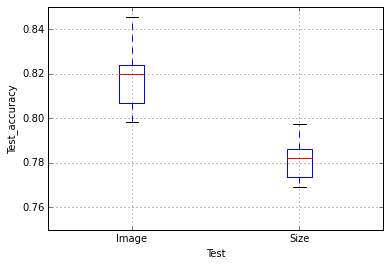

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)

data=[scores, scores_area]
# データをセット
bp = ax.boxplot(data)

ax.set_xticklabels(["Image", 'Size'])
plt.grid()
plt.xlabel('Test')
plt.ylabel('Test_accuracy')

plt.title('')
plt.ylim([0.75,0.85])

plt.show()

In [54]:
import pickle
dic={}
dic["Image"]=scores
dic["Size"]=scores_area

with open('accuracy1.dump','w') as f:
    pickle.dump(dic, f)

In [55]:
with open('accuracy.dump','r') as f:
    data = pickle.load(f)

###Save final model